<a href="https://colab.research.google.com/github/harshvardhan981/Fake_News_Detector/blob/main/fakenews2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


!pip install --upgrade transformers peft accelerate huggingface-hub datasets

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from nltk.corpus import stopwords
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

import torch
import transformers
import datasets
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer,AutoModel,TrainingArguments
from transformers import AutoModelForSequenceClassification,AutoConfig
from transformers import Trainer,BertModel,BertForSequenceClassification
from transformers import DataCollatorWithPadding

from warnings import simplefilter
simplefilter("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.0/411.0 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.2/481.2 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [3]:
import os
import wandb

# Set API key as an environment variable (Recommended)
os.environ["WANDB_API_KEY"] = "6674505d166876897d9dd5266ea47f1380fec9da"

# Log in to Weights & Biases
wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 22051453 (aratrika123) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
!pip install python-dotenv
from dotenv import load_dotenv
import os
import wandb

load_dotenv()  # Load environment variables from .env file

wandb.login(key=os.getenv("6674505d166876897d9dd5266ea47f1380fec9da"))


True

In [5]:
!pip install evaluate

import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00


In [33]:
data =pd.read_csv('https://zenodo.org/record/4561253/files/WELFake_Dataset.csv?download=1')
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


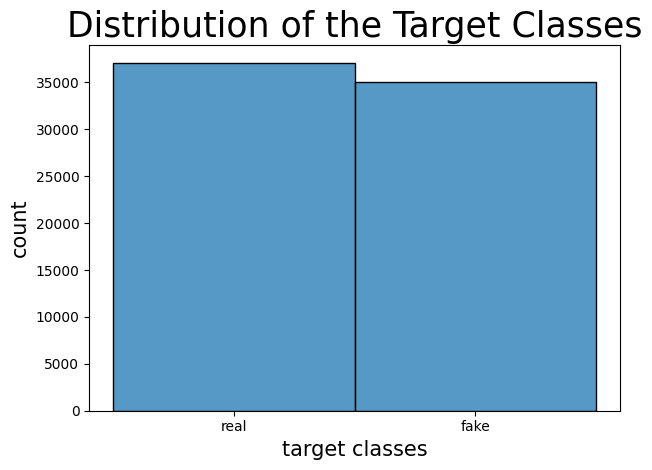

In [34]:
# Check if the column 'label' exists before renaming (it was renamed in a previous step)
if 'label' in data.columns:
    # If it does exist, rename it to 'labels'
    data.rename(columns={'label': 'labels'}, inplace=True)
else:
    # Otherwise, do nothing
    pass

# Proceed with the rest of your code
news_map = {1: 'real', 0: 'fake'}
data['label_names'] = data['labels'].map(news_map)

sns.histplot(data=data.label_names)
plt.title('Distribution of the Target Classes', fontsize=25)
plt.xlabel('target classes', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.tight_layout()

In [35]:
# Check if the column 'Unnamed: 0' exists before dropping
if 'Unnamed: 0' in data.columns:
    data.drop('Unnamed: 0', axis=1, inplace=True)

# Proceed with renaming the column
data.rename(columns={'label': 'labels'}, inplace=True)

data.head()

,title,text,labels,label_names
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,real
1,NaN,Did they post their votes for Hillary already?,1,real
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,real
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,fake
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,real


In [36]:
data.isna().sum()

,0
title,558
text,39
labels,0
label_names,0


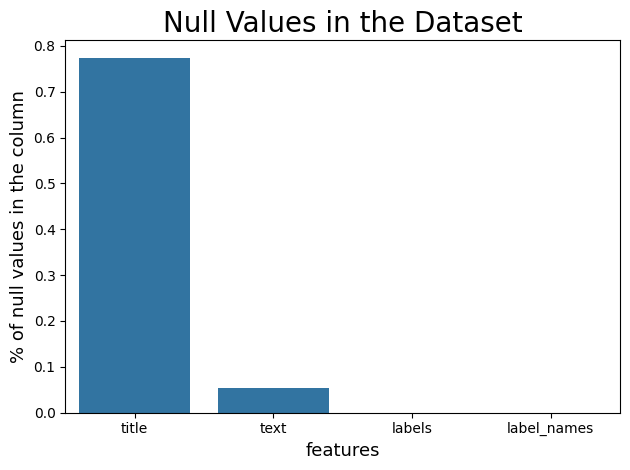

In [37]:
def plot_nulls(data,title,x_axis_label,y_axis_label):

    # Number of nulls for each column
    # Get counts of True (null) values for each column
    null_counts = data.isnull().sum()
    # Calculate percentage of null values
    data_nulls = (null_counts / len(data) * 100).reset_index(name='count')

    sns.barplot(data_nulls,x="index",y="count")
    plt.title(title,fontsize=20)
    plt.xlabel(x_axis_label,fontsize=13)
    plt.ylabel(y_axis_label,fontsize=13)

    plt.tight_layout()
    plt.show()

plot_nulls(data,"Null Values in the Dataset",'features','% of null values in the column')

In [38]:
data.dropna(axis=0,inplace=True)

In [39]:
data.duplicated().sum()

np.int64(8416)

In [40]:
data.drop_duplicates(inplace=True)

data.shape

(63121, 4)

In [41]:
data = data.sample(frac=1,random_state=42)

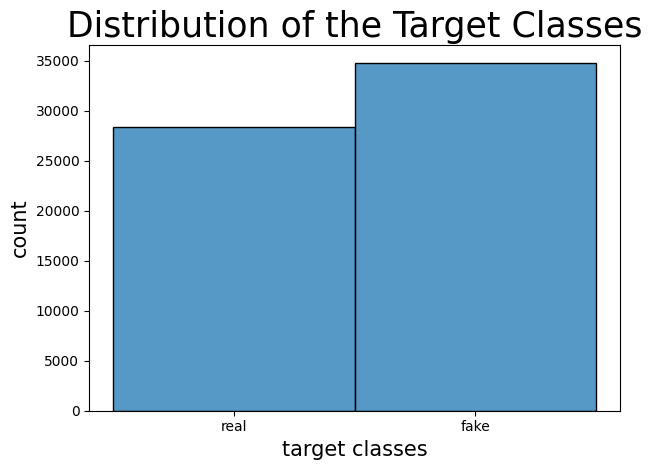

In [42]:
news_map = {1:'real',0:'fake'}
data['label_names'] = data['labels'].map(news_map)

sns.histplot(data=data.label_names)
plt.title('Distribution of the Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tight_layout()

Column 'label' not found in the DataFrame.


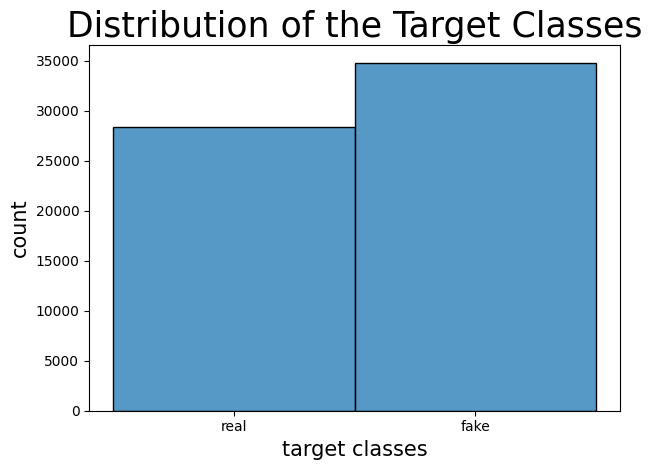

In [43]:
# Check if the column 'label' exists before renaming
if 'label' in data.columns:
    data.rename(columns={'label': 'labels'}, inplace=True)
else:
    print("Column 'label' not found in the DataFrame.")

# Proceed with the rest of your code
news_map = {1:'real',0:'fake'}
data['label_names'] = data['labels'].map(news_map)

sns.histplot(data=data.label_names)
plt.title('Distribution of the Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tight_layout()

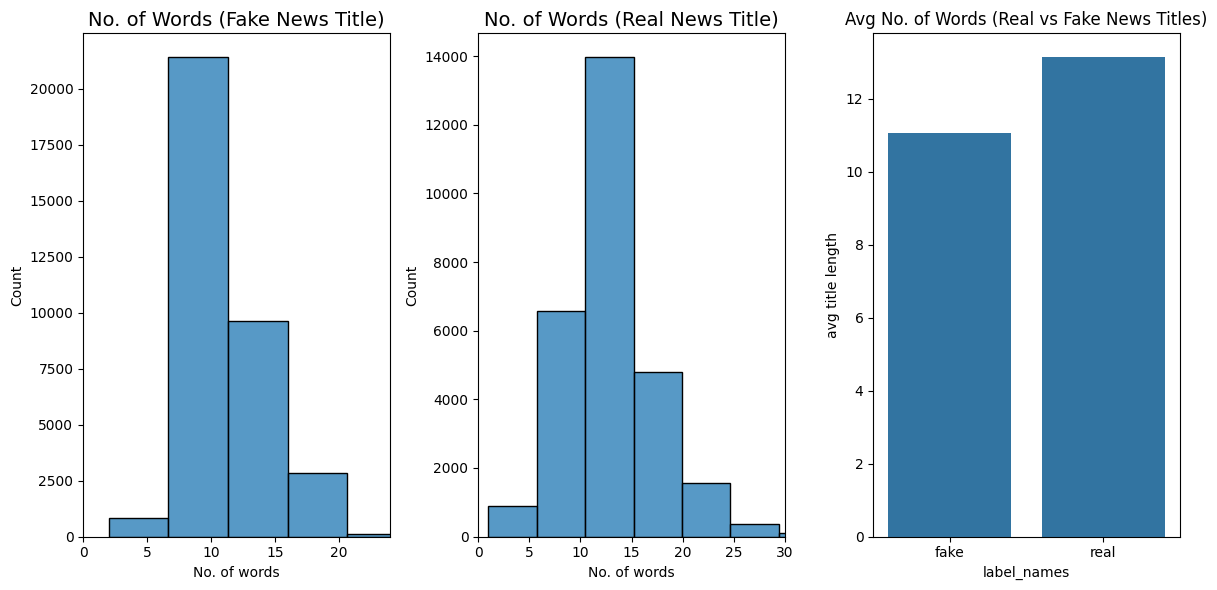

In [44]:
fake_title = data.loc[data.labels == 0]['title'].apply(lambda x: len(x.split()))
real_title = data.loc[data.labels == 1]['title'].apply(lambda x: len(x.split()))

data['title_length'] = data['title'].apply(lambda x: len(x.split()))

avg_title = data.groupby('label_names')['title_length'].mean().reset_index(name='avg title length')
##########################

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1 = sns.histplot(fake_title,ax=ax1,bins=6)
ax1.set_xlim(0,24)
ax1.set_xlabel('No. of words')
ax1.set_title("No. of Words (Fake News Title)",fontsize=14)

ax2 = sns.histplot(real_title,ax=ax2,bins=15)
ax2.set_xlim(0,30)
ax2.set_xlabel('No. of words')
ax2.set_title("No. of Words (Real News Title)",fontsize=14)

ax3 = sns.barplot(data=avg_title,x='label_names',y='avg title length')
ax3.set_title("Avg No. of Words (Real vs Fake News Titles)",fontsize=12)

plt.tight_layout()


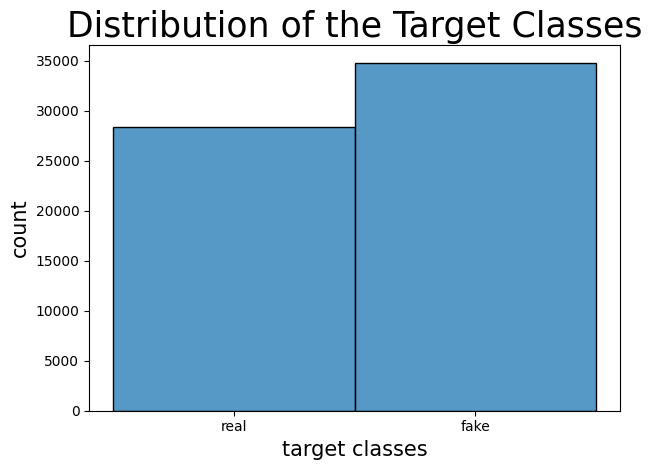

In [45]:
# Check if the column 'label' exists before renaming (it was renamed in a previous step)
if 'label' in data.columns:
    # If it does exist, rename it to 'labels'
    data.rename(columns={'label': 'labels'}, inplace=True)
else:
    # Otherwise, do nothing
    pass

# Proceed with the rest of your code
news_map = {1: 'real', 0: 'fake'}
data['label_names'] = data['labels'].map(news_map)

sns.histplot(data=data.label_names)
plt.title('Distribution of the Target Classes', fontsize=25)
plt.xlabel('target classes', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.tight_layout()

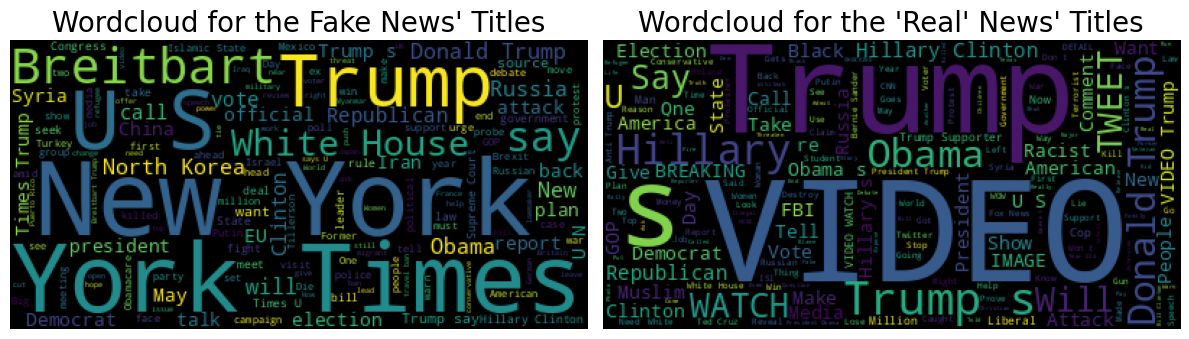

In [46]:
text_fake = ' '.join(data.loc[data.labels == 0]['title'])
text_real = ' '.join(data.loc[data.labels == 1]['title'])

wordcloud_fake = WordCloud().generate(text_fake)
wordcloud_real = WordCloud().generate(text_real)

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(12,6))

ax1.imshow(wordcloud_fake)
ax1.axis("off")
ax1.set_title("Wordcloud for the Fake News' Titles",fontsize=20)

ax2.imshow(wordcloud_real)
ax2.axis("off")
ax2.set_title("Wordcloud for the 'Real' News' Titles",fontsize=20)

plt.tight_layout()
plt.show()

In [47]:
import spacy

# Remove the corrupted model
!python -m spacy validate
!python -m spacy download en_core_web_sm --force

# Try loading it again
nlp = spacy.load("en_core_web_sm")
print("Model loaded successfully!")


✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.8.4) =================
ℹ spaCy installation: /usr/local/lib/python3.11/dist-packages/spacy

NAME             SPACY            VERSION                            
en_core_web_sm   >=3.8.0,<3.9.0   3.8.0   ✔

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: en-core-web-sm
    Found existing installation: en_core_web_sm 3.8.0
    Uninstalling en_core_web_sm-3.8.0:
      Successfully uninstalled en_core_web_sm-3.8.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Model loaded successfully!


In [48]:
nlp = spacy.load("en_core_web_sm")

data2 = data.copy()


def clean_text(text):

    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    return text


data2['title'] = data2['title'].apply(clean_text)

In [49]:
data2.drop(columns=['text','title_length'],axis=1,inplace=True)

data2.rename(columns={'title':'text'},inplace=True)

data2.head()

,text,labels,label_names
71361,donald trump responds to mockery over fake sw...,1,real
11496,tweetwave,1,real
20292,rubio says prospect of trump president is worr...,0,fake
38855,trump lifts cyber command status to boost cybe...,0,fake
20416,the biggest republican lies about the economy...,1,real


In [50]:
data3 = data2.copy()

X = data3['text']
y = data3['labels']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [51]:
# Create tokenization and modelling pipeline
model_NB = Pipeline([
                    ("tfidf",TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf",MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_NB.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [52]:
test_score = model_NB.score(X_test,y_test)

test_score

0.8790727147911496

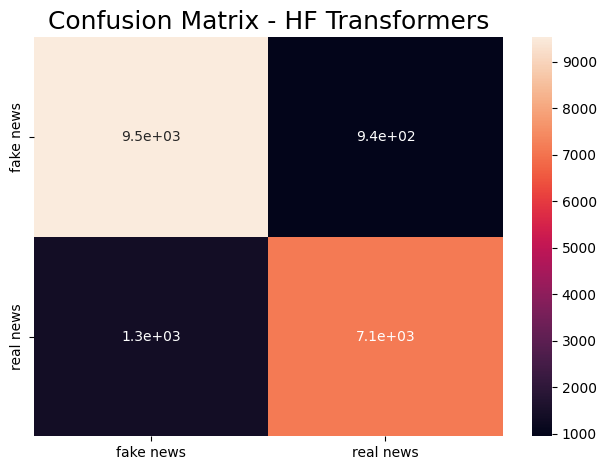

In [53]:
y_pred = model_NB.predict(X_test)

# Generate array of values for confusion matrix
cm = confusion_matrix(y_test,y_pred)

ax = sns.heatmap(cm,annot=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

In [54]:
model_ckpt = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [55]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

In [56]:
train,test      = train_test_split(data2,test_size=0.3,stratify=data2['labels'])
test,validation = train_test_split(test,test_size=1/3,stratify=test['labels'])

train.shape, test.shape, validation.shape

((44184, 3), (12624, 3), (6313, 3))

In [57]:
dataset = DatasetDict(
    {'train':Dataset.from_pandas(train,preserve_index=False),
     'test':Dataset.from_pandas(test,preserve_index=False),
     'validation': Dataset.from_pandas(validation,preserve_index=False)
     }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 44184
    })
    test: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 12624
    })
    validation: Dataset({
        features: ['text', 'labels', 'label_names'],
        num_rows: 6313
    })
})

In [58]:
dataset['train'][0], dataset['train'][1], dataset['train'][2]

({'text': 'japans dentsu gets only small fine for overtime breaches despite outcry',
  'labels': 0,
  'label_names': 'fake'},
 {'text': 'just in washington post exposed russia story ‘fcking crap shoot…maybe it doesn’t exist’ video',
  'labels': 1,
  'label_names': 'real'},
 {'text': 'fox news legal analyst comey’s big lie exposed after recent discovery of clintonlynch tarmac meeting documents',
  'labels': 1,
  'label_names': 'real'})

In [59]:
def tokenize(batch):
    temp = tokenizer(batch['text'],padding=True,truncation=True)
    return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 2900, 2015, 21418, 6342, 4152, 2069, 2235, 2986, 2005, 12253, 12510, 2229, 2750, 2041, 26775, 2100, 102, 0, 0, 0, 0, 0], [101, 2074, 1999, 2899, 2695, 6086, 3607, 2466, 1520, 4429, 6834, 10231, 5607, 1529, 2672, 2009, 2987, 1521, 1056, 4839, 1521, 2678, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [60]:
encoded_dataset = dataset.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/44184 [00:00<?, ? examples/s]

Map:   0%|          | 0/12624 [00:00<?, ? examples/s]

Map:   0%|          | 0/6313 [00:00<?, ? examples/s]

In [61]:
# label2id, id2label: mapping between labels (0, 1, 2 ...) and label names (love, fear, surprise ...)
label2id = {x['label_names']:x['labels'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'fake': 0, 'real': 1}, {0: 'fake', 1: 'real'})

In [62]:
from peft import PeftModel,PeftConfig,get_peft_model,LoraConfig


In [63]:
num_labels = len(label2id)

# Where to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id,id2label=id2label)

# to(device) ==> the model will be trained on cuda (GPU)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,config=config).to(device)

peft_config = LoraConfig(
    task_type="SEQ_CLS",
    # Rank: original matrix decomposed into 32 rows and columns
    r=32,
    # lora_alpha: scaling factor
    lora_alpha=64,
    lora_dropout=0.05,
    target_modules = ["query"]
)

model = get_peft_model(model,peft_config)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
batch_size = 16

training_dir = "bert_base_train_dir"

training_args = TrainingArguments(output_dir=training_dir,
                                  overwrite_output_dir = True,
                                  num_train_epochs = 5,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm = False
)

In [75]:
# Build compute metrics function
accuracy = evaluate.load("accuracy")

def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels,preds)

    return {"accuracy":acc}

In [76]:
# Use data_collector to convert the samples to PyTorch tensors and concatenate them with the correct amount of padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_dataset['train'],
                  eval_dataset=encoded_dataset['validation'],
                  tokenizer=tokenizer,
                  data_collator=data_collator)

trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.283200,0.282329,0.889910
2,0.264500,0.267152,0.897830
3,0.253200,0.266430,0.900206
4,0.244300,0.257434,0.902424
5,0.255300,0.257031,0.901473


TrainOutput(global_step=13810, training_loss=0.2645252092431888, metrics={'train_runtime': 2975.8316, 'train_samples_per_second': 74.238, 'train_steps_per_second': 4.641, 'total_flos': 1.20027780007632e+16, 'train_loss': 0.2645252092431888, 'epoch': 5.0})

In [78]:
preds_output = trainer.predict(encoded_dataset['test'])

In [79]:
preds_output.metrics

{'test_loss': 0.266880601644516,
 'test_accuracy': 0.8959125475285171,
 'test_runtime': 68.2392,
 'test_samples_per_second': 184.996,
 'test_steps_per_second': 11.562}

In [80]:
y_pred = np.argmax(preds_output.predictions,axis=1)

y_true = encoded_dataset['test'][:]['labels']

In [81]:
print(classification_report(y_true,y_pred,target_names=list(label2id)))

              precision    recall  f1-score   support

        fake       0.90      0.91      0.91      6958
        real       0.89      0.88      0.88      5666

    accuracy                           0.90     12624
   macro avg       0.90      0.89      0.89     12624
weighted avg       0.90      0.90      0.90     12624



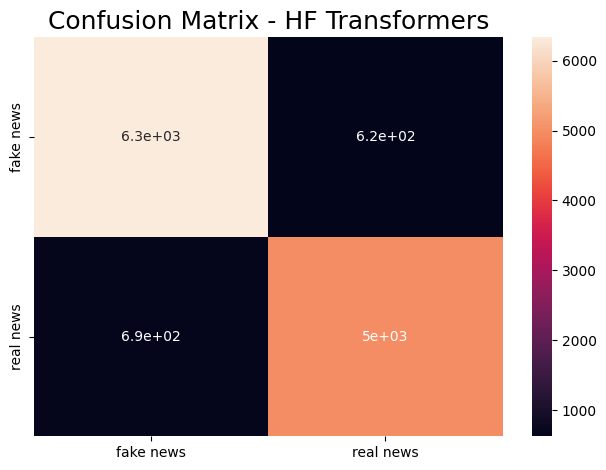

In [82]:
cm = confusion_matrix(y_true,y_pred)

ax = sns.heatmap(cm,annot=True)
ax.xaxis.set_ticklabels(['fake news','real news'])
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

In [ ]:
def predict_news():
    user_input = input("\nEnter a news headline to check if it's FAKE or REAL: ")
    cleaned_input = clean_text(user_input)
    prediction = model_NB.predict([cleaned_input])[0]
    label = "REAL" if prediction == 1 else "FAKE"
    print(f"\n🔎 **Prediction:** This news is **{label}**!")

# Run the prediction function
predict_news()